In [66]:
import tensorflow as tf
from keras.api.layers import LSTM, Dense
from keras.api.preprocessing import timeseries_dataset_from_array
import pandas as pd
import matplotlib.pyplot as plt

In [67]:
df = pd.read_csv('climate.csv', sep=',')
data = df.iloc[:,[1,2,5,7,8,10,11]].values
data

array([[ 9.96520e+02, -8.02000e+00,  9.33000e+01, ...,  2.20000e-01,
         3.12000e+00,  1.30775e+03],
       [ 9.96570e+02, -8.41000e+00,  9.34000e+01, ...,  2.10000e-01,
         3.03000e+00,  1.30980e+03],
       [ 9.96530e+02, -8.51000e+00,  9.39000e+01, ...,  2.00000e-01,
         3.02000e+00,  1.31024e+03],
       ...,
       [ 9.99820e+02, -3.16000e+00,  6.79100e+01, ...,  1.55000e+00,
         3.28000e+00,  1.28839e+03],
       [ 9.99810e+02, -4.23000e+00,  7.18000e+01, ...,  1.26000e+00,
         3.20000e+00,  1.29356e+03],
       [ 9.99820e+02, -4.82000e+00,  7.57000e+01, ...,  1.04000e+00,
         3.23000e+00,  1.29638e+03]])

In [68]:
def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

In [69]:
train_split = int(0.715 * int(df.shape[0]))
data = normalize(data, train_split)
train_data = data[:train_split]
val_data = data[train_split:]

In [70]:
#Xác định phương thức dự báo
past = 720
future = 72
step = 6
batch_size = 256

In [71]:
start = past + future
end = start + train_split
x_train = train_data
y_train = data[start:end]
sequence_length = int(past / step)

In [72]:
dataset_train = timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

In [73]:
x_end = len(val_data) - past - future
label_start = train_split + past + future
x_val = val_data[:x_end]
y_val = data[label_start:]

In [74]:
dataset_val = timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

In [75]:
from keras import Input
learning_rate = 0.01
model = tf.keras.Sequential()
model.add(Input(shape=(sequence_length, 7)))
model.add(LSTM(32))
model.add(Dense(1))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 32)             │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,153 (20.13 KB)

 Trainable params: 5,153 (20.13 KB)

 Non-trainable params: 0 (0.00 B)

In [76]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                           patience=3)

In [77]:
# Huấn luyện
epochs = 10
history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback],
)

Epoch 1/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 101s 85ms/step - loss: 0.9377 - val_loss: 0.8577
Epoch 2/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 107s 91ms/step - loss: 0.9112 - val_loss: 0.8564
Epoch 3/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 113s 96ms/step - loss: 0.9105 - val_loss: 0.8515
Epoch 4/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 109s 93ms/step - loss: 0.9099 - val_loss: 0.8507
Epoch 5/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 115s 98ms/step - loss: 0.9095 - val_loss: 0.8493
Epoch 6/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 111s 95ms/step - loss: 0.9091 - val_loss: 0.8512
Epoch 7/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 116s 99ms/step - loss: 0.9089 - val_loss: 0.8524
Epoch 8/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 120s 102ms/step - loss: 0.9098 - val_loss: 0.8491
Epoch 9/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 118s 101ms/step - loss: 0.9082 - val_loss: 0.8510
Epoch 10/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 116s 99ms/step - loss: 0.9088 - val_loss: 0.8472


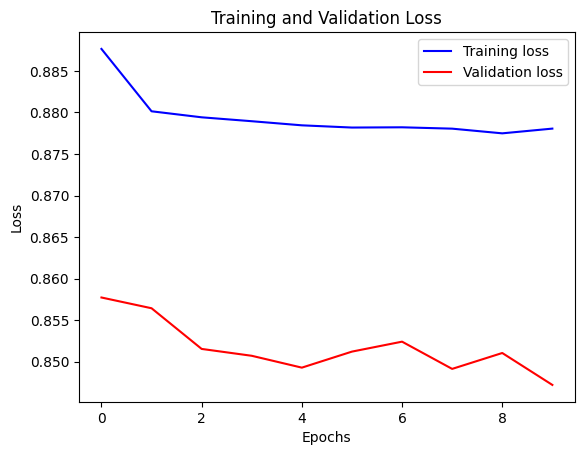

In [78]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
visualize_loss(history, "Training and Validation Loss")